In [1]:
from src import *

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

## Table of Contents
- [Feature Extraction](feature)
- [Data Splitting](data)
- [Inference](#analysis)

In [2]:
# Loading gradients 
subject_grad = load('./resources/static_grad/Rest_grad.pkl')
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

#### Feature Extraction

In [3]:
index2region = load('./resources/yeo7region400.pkl')
subjects     = list(subject_grad.keys())
regions      = list(index2region.keys())
print(subjects)
print(regions)

['S17', 'S02', 'S05', 'S10', 'S11', 'S04', 'S19', 'S03', 'S16', 'S01', 'S14', 'S09', 'S13', 'S06', 'S07', 'S08', 'S15', 'S29', 'S21', 'S26', 'S27', 'S32', 'S20', 'S28', 'S22', 'S25', 'S30', 'S31', 'S24', 'S23']
['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']


In [95]:
feat = existing_psy[0]
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
order    = np.argsort(psyscore)
print(feat)

cov_total


In [96]:
# 1. Volume computing 
features = np.zeros((len(subjects), len(regions)))
for sidx in range(len(subjects)):
    for ridx in range(len(regions)):
        features[sidx, ridx] = network_volume(subject_grad[subjects[sidx]], index2region[regions[ridx]])

gradients = np.asarray([subject_grad[s] for s in subjects])

# 2/3. Full gradients and variances
G1,G2,coloring = [],[],[]
V1,V2,c2       = [],[],[]

for i in order:
    G1 += list(gradients[i][:,0])
    G2 += list(gradients[i][:,1])
    coloring += [psyscore[i]] * 400
    
    V1 += [gradients[i][:,0].std()]
    V2 += [gradients[i][:,2].std()]
    c2 += [psyscore[i]]

In [110]:
# 4. Distribution vectors
D1,D2,c3 = [], [], []
nbin = 15
d2gradients = np.zeros((len(order), nbin, 2))
for i in order:
    d2gradients[i,:,0] = np.histogram(gradients[i][:,0], bins=nbin)[0]
    d2gradients[i,:,1] = np.histogram(gradients[i][:,1], bins=nbin)[0]

    D1 += list(np.histogram(gradients[i][:,0], density=True, bins=nbin)[0])
    D2 += list(np.histogram(gradients[i][:,0], density=True, bins=nbin)[0])
    c3 += [psyscore[i]] * nbin

dgradients = d2gradients[:,:,1]

#### Data Splitting: training / validation
We split accordingly to have the same number of above-mean and below-mean points

In [111]:
# # feature of interest
# grad_idx = 0
# feat     = "erq_es"
# cutoff   = behavioural[['ID', feat]].mean().iloc[0]
# nb_above = np.sum(np.array(list(behavioural[feat])) > cutoff)
# nb_below = np.sum(np.array(list(behavioural[feat])) <= cutoff)

# np.random.seed(0)
# a = np.random.choice(np.where(behavioural[feat] > cutoff)[0], int(nb_above/2), replace=False)
# b = np.random.choice(np.where(behavioural[feat] <= cutoff)[0], int(nb_below/2), replace=False)

# trainIds = list(behavioural.ID.iloc[a]) + list(behavioural.ID.iloc[b])
# valIds   = [b for b in list(behavioural.ID) if b not in trainIds]

# # We use first gradient as a point
# X_train = np.asarray([subject_grad[t][:,grad_idx] for t in trainIds])
# y_train = np.asarray([behavioural[behavioural.ID == t][feat].iloc[0] for t in trainIds])

# X_val = np.asarray([subject_grad[t][:,grad_idx] for t in valIds])
# y_val = np.asarray([behavioural[behavioural.ID == t][feat].iloc[0] for t in valIds])

In [112]:
# # forcing the style since sns changes it when we call default set size
# plt.style.use('fivethirtyeight')
# plt.figure(figsize=(15,5))
# sw = 40
# plt.plot(overlap_add(X_train[8], sw), label=y_train[8])
# plt.plot(overlap_add(X_train[9], sw), label=y_train[9])
# plt.plot(overlap_add(X_train[1], sw), label=y_train[1])
# plt.plot(overlap_add(X_train[6], sw), label=y_train[6])
# plt.plot(overlap_add(X_train[4], sw), label=y_train[4])
# plt.title("Gradient 1 (400 parcels) of different subjects with behavioural value")
# plt.legend()

#### Visual difference

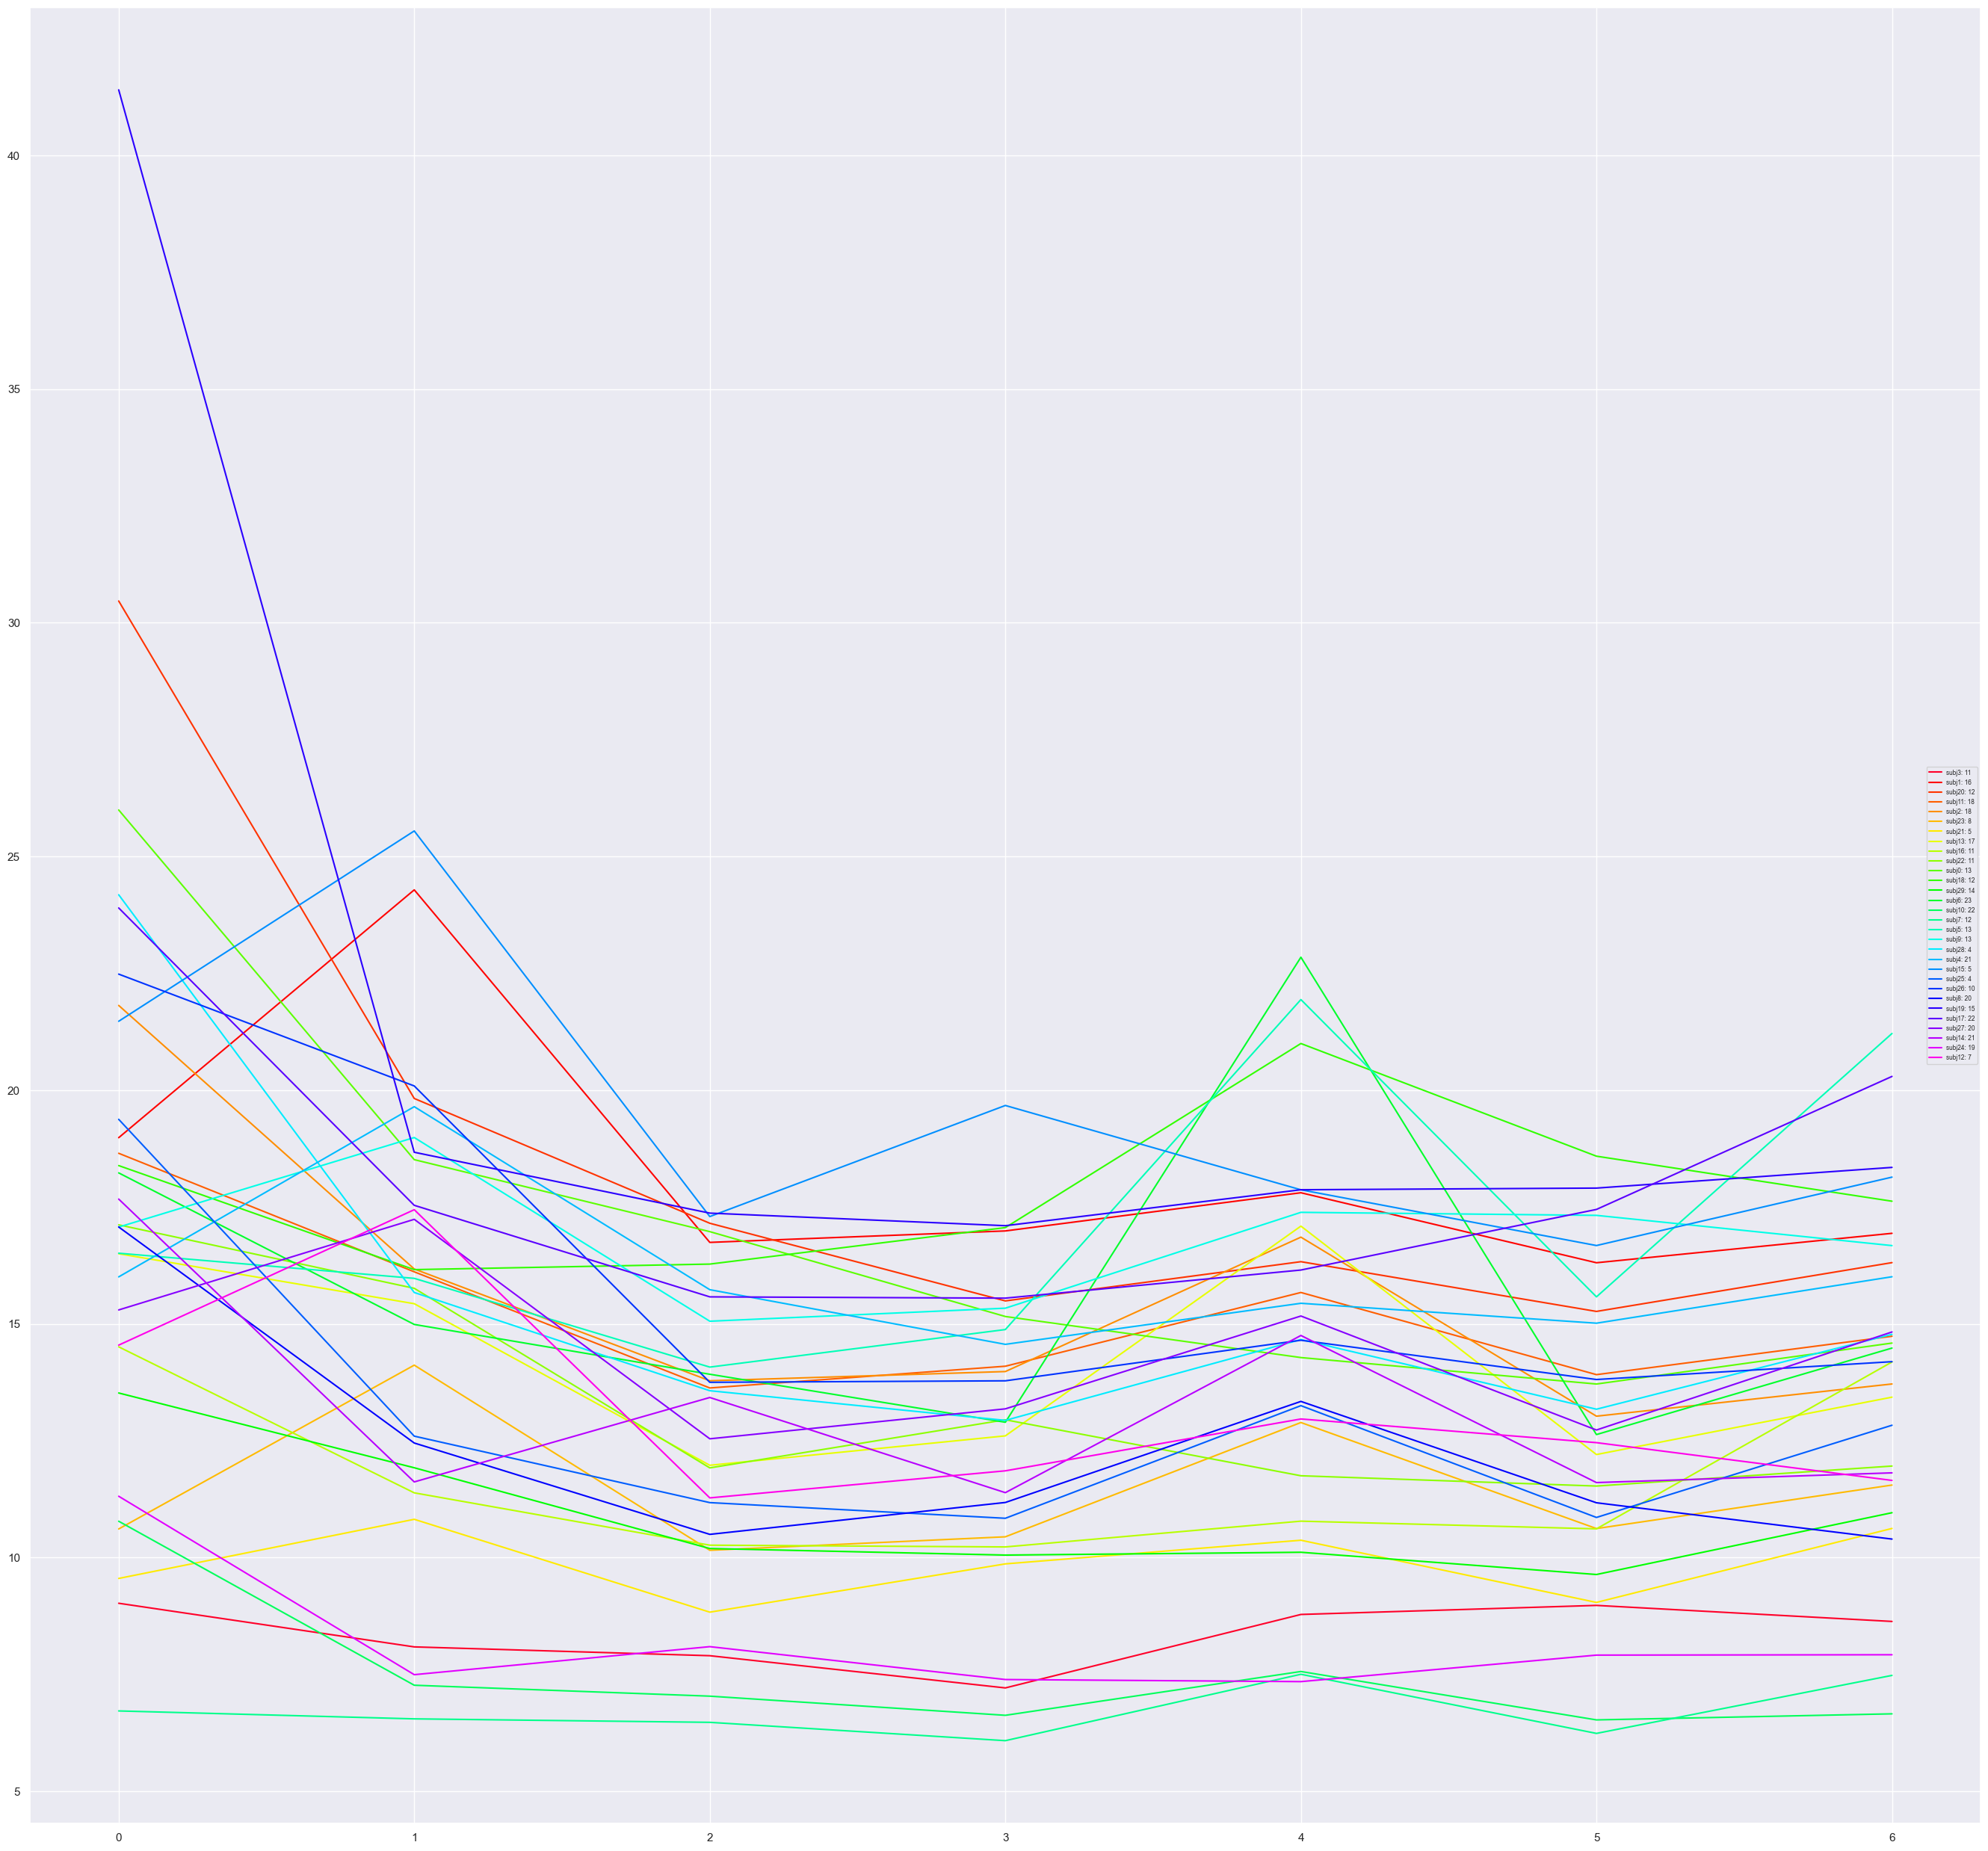

In [113]:
NUM_COLORS = len(features)
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in order:
    plt.plot(features[i], label='subj{}: {}'.format(i, psyscore[i]))

plt.legend(loc=5, prop={'size':6})

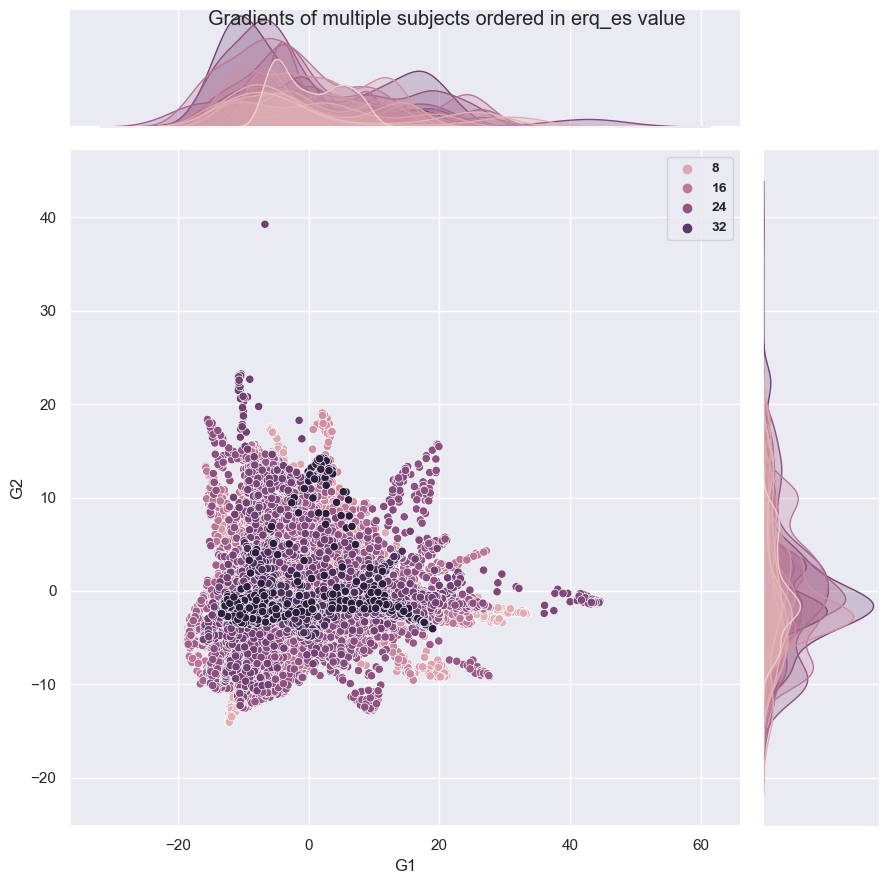

In [114]:
sns.set(rc={'figure.figsize':(30,30)})

tmp_df = {"G1": G1 , "G2": G2, feat: coloring}

ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue=feat, height=9)
ax.fig.suptitle("Gradients of multiple subjects ordered in {} value".format(feat))
legend_properties = {'weight':'bold','size':10}
ax.ax_joint.legend(prop=legend_properties,loc='upper right')

#### Regress / Predictive

In [115]:
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

SVM and Ridge on Distributions

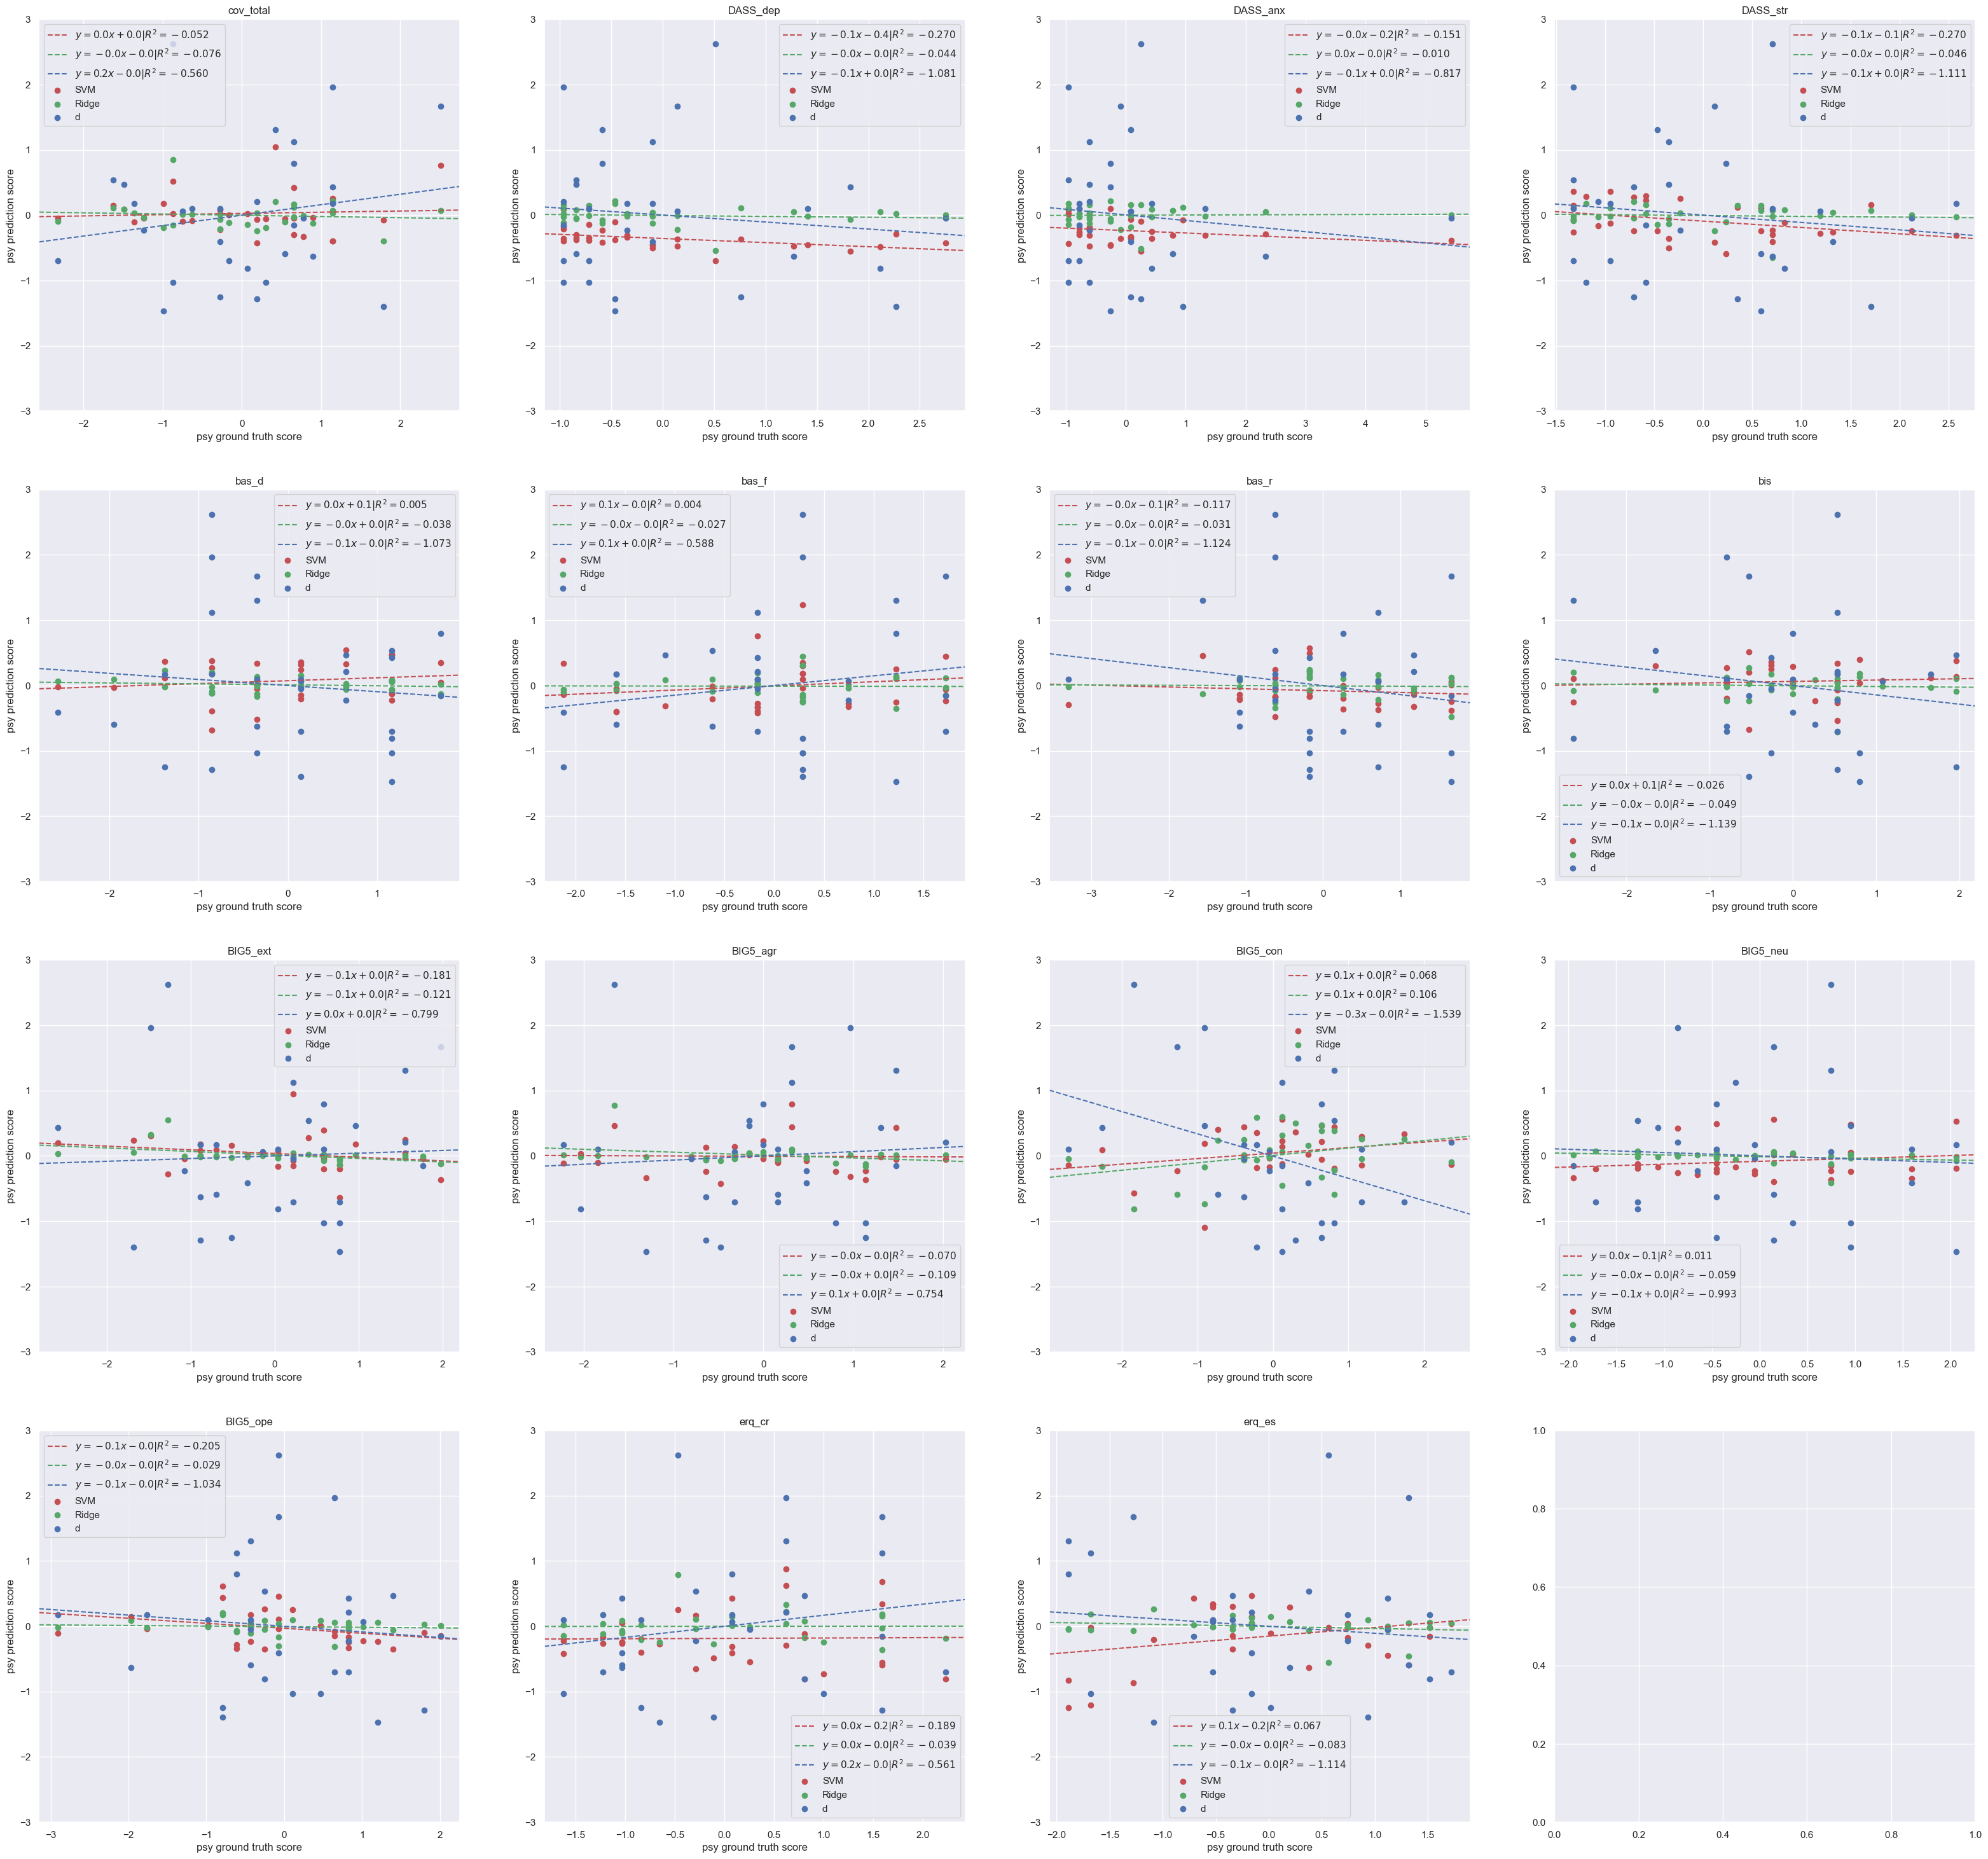

In [150]:
fig, ax = plt.subplots(4,4, figsize=(35,35))

for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    # regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    regr = SVR(C=1.0, epsilon=0.2)
    clf  = Ridge(alpha=1.0)
    # leave one out val prediction score
    
    pts  = []
    pts2 = []
    pts3 = []
    for i in range(len(psyscore)):
        tmp  = np.concatenate([psyscore[:i], psyscore[i+1:]])
        tmp2 = np.concatenate([dgradients[:i].max(axis=1), dgradients[i+1:].max(axis=1)])
        y = tmp
        y, m, s = zscore(tmp, ret_param=True)
        regr.fit(tmp2[:,None], y)
        clf.fit(tmp2[:,None], y)

        topredict = dgradients[i].max()
        gt = (psyscore[i]-m)/s
        # gt = psyscore[i]
        pts.append([regr.predict([[topredict]])[0], gt])
        pts2.append([clf.predict([[topredict]])[0], gt])
        pts3.append([topredict, gt])
    pts  = np.asarray(pts)
    pts2 = np.asarray(pts2)
    pts3 = np.asarray(pts3)
    pts3[:,0] = zscore(pts3[:,0])

    r1 = r2_score(pts[:,1],pts[:,0])
    r2 = r2_score(pts2[:,1],pts2[:,0])
    r3 = r2_score(pts3[:,1],pts3[:,0])
    m1, b1 = np.polyfit(pts[:,1], pts[:,0], deg=1)
    m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    m3, b3 = np.polyfit(pts3[:,1], pts3[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b1), linestyle='--', slope=m1, label=f'$y = {m1:.1f}x {b1:+.1f} | R^2={r1:.3f}$', color='r')
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$y = {m2:.1f}x {b2:+.1f} | R^2={r2:.3f}$', color='g')
    ax[r,c].axline(xy1=(0, b3), linestyle='--', slope=m3, label=f'$y = {m3:.1f}x {b3:+.1f} | R^2={r3:.3f}$', color='b')
    # ax[r,c].axline(xy1=(3, 3), linestyle='--', slope=1, label='ideal prediction', color='y')

    ax[r,c].scatter(pts[:,1], pts[:,0], color='r',label='SVM')
    ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")
    ax[r,c].scatter(pts3[:,1], pts3[:,0], color='b', label="d")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()
    ax[r,c].set_ylim(-3,3)

SVM and Ridge on Gradients Variances

In [83]:
vgradients = np.stack([V1,V2]).T

In [84]:
fig, ax = plt.subplots(4,4, figsize=(35,35))

for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    clf  = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
    # leave one out val prediction score
    
    pts = []
    pts2 = []
    for i in range(len(psyscore)):
        tmp  = np.concatenate([psyscore[:i], psyscore[i+1:]])
        tmp2 = np.concatenate([vgradients[:i], vgradients[i+1:]])
        y = tmp 
        # y, m, s = zscore(tmp, ret_param=True)
        regr.fit(tmp2, y)
        clf.fit(tmp2, y)

        topredict = vgradients[i]
        # gt = (psyscore[i]-m)/s
        gt = psyscore[i]
        pts.append([regr.predict([topredict])[0], gt])
        pts2.append([clf.predict([topredict])[0], gt])
    pts  = np.asarray(pts)
    pts2 = np.asarray(pts2)

    r1 = r2_score(pts[:,1],pts[:,0])
    r2 = r2_score(pts2[:,1],pts2[:,0])
    m1, b1 = np.polyfit(pts[:,1], pts[:,0], deg=1)
    m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b1), linestyle='--', slope=m1, label=f'$y = {m1:.1f}x {b1:+.1f} | R^2={r1:.3f}$', color='r')
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$y = {m2:.1f}x {b2:+.1f} | R^2={r2:.3f}$', color='g')
    ax[r,c].axline(xy1=(3, 3), linestyle='--', slope=1, label='ideal prediction', color='y')

    ax[r,c].scatter(pts[:,1], pts[:,0], color='r',label='SVM')
    ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

SVM and Ridge on Features

In [54]:
fig, ax = plt.subplots(4,4, figsize=(35,35))

for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    clf  = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
    # leave one out val prediction score
    
    pts = []
    pts2 = []
    for i in range(len(psyscore)):
        tmp  = np.concatenate([psyscore[:i], psyscore[i+1:]])
        tmp2 = np.concatenate([features[:i], features[i+1:]])
        y = tmp 
        # y, m, s = zscore(tmp, ret_param=True)
        regr.fit(tmp2, y)
        clf.fit(tmp2, y)

        topredict = features[i]
        # gt = (psyscore[i]-m)/s
        gt = psyscore[i]
        pts.append([regr.predict([topredict])[0], gt])
        pts2.append([clf.predict([topredict])[0], gt])
    pts  = np.asarray(pts)
    pts2 = np.asarray(pts2)

    r1 = r2_score(pts[:,1],pts[:,0])
    r2 = r2_score(pts2[:,1],pts2[:,0])
    m1, b1 = np.polyfit(pts[:,1], pts[:,0], deg=1)
    m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b1), linestyle='--', slope=m1, label=f'$y = {m1:.1f}x {b1:+.1f} | R^2={r1:.3f}$', color='r')
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$y = {m2:.1f}x {b2:+.1f} | R^2={r2:.3f}$', color='g')
    ax[r,c].axline(xy1=(3, 3), linestyle='--', slope=1, label='ideal prediction', color='y')

    ax[r,c].scatter(pts[:,1], pts[:,0], color='r',label='SVM')
    ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

SVM and Ridge on Gradients

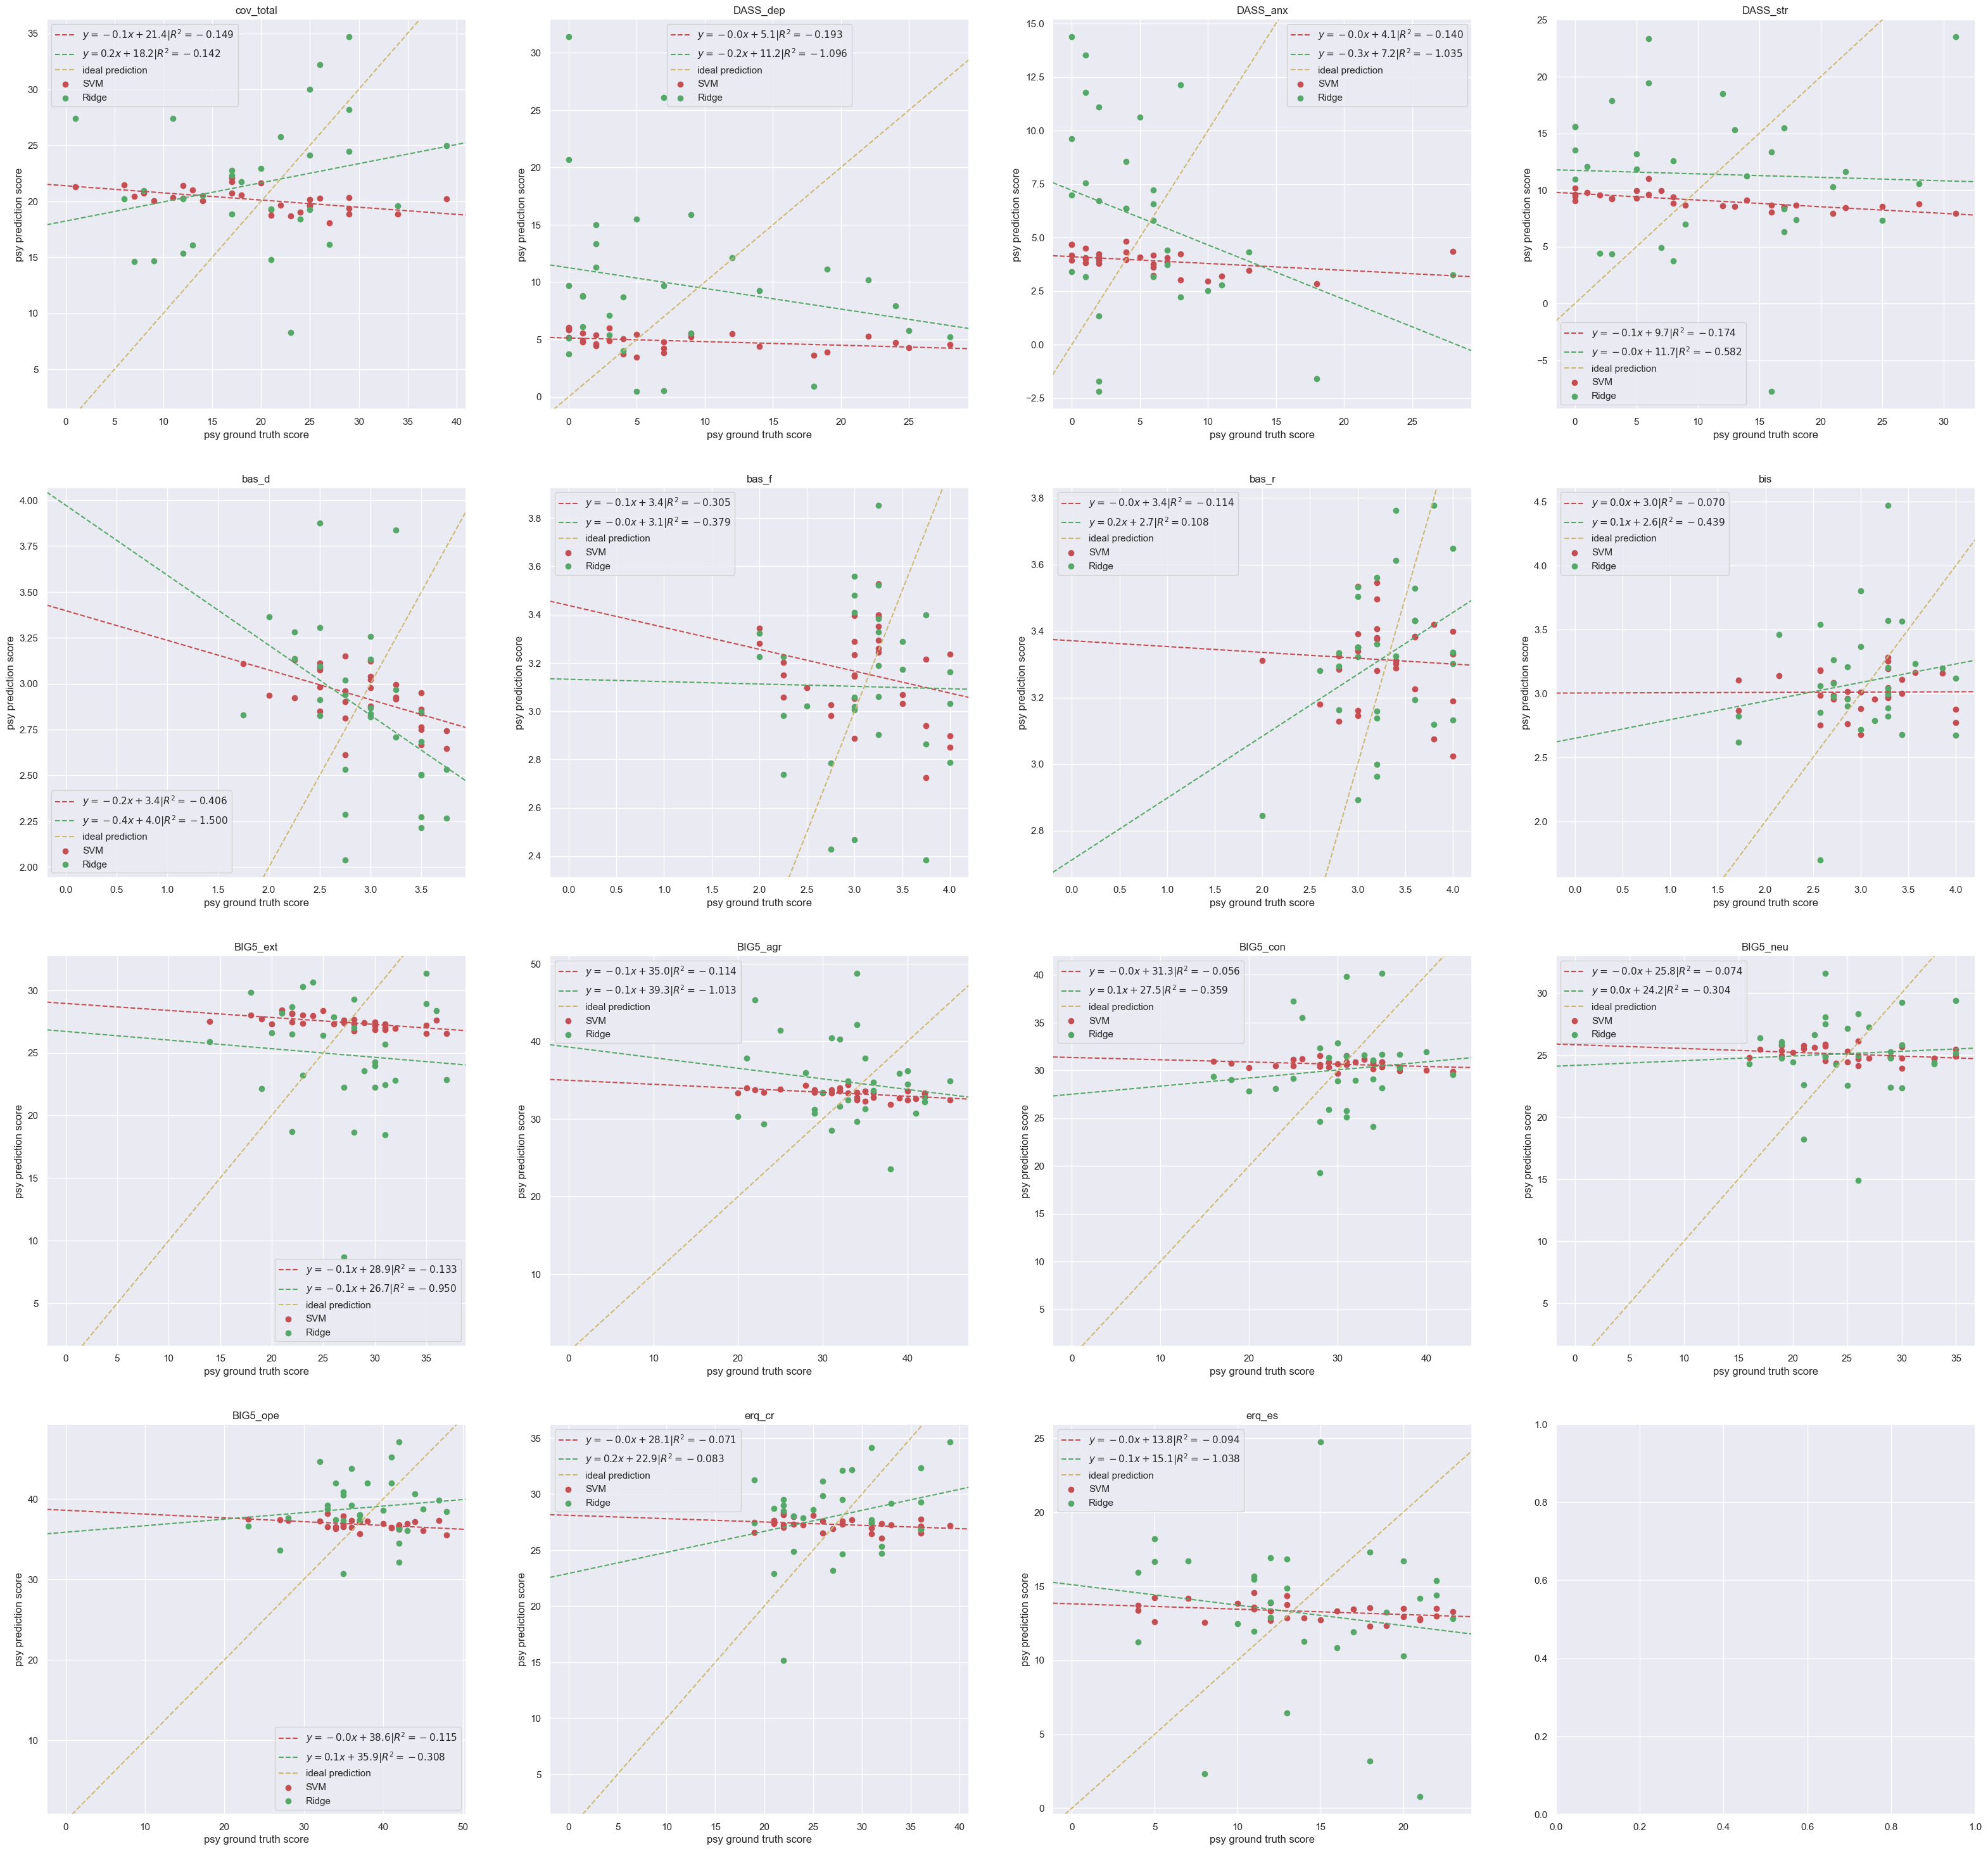

In [63]:
fig, ax  = plt.subplots(4,4, figsize=(35,35))
grad_idx = 1
Y =  gradients[:,:,grad_idx]
for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    clf  = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
    # leave one out val prediction score
    
    pts = []
    pts2 = []
    for i in range(len(psyscore)):
        tmp  = np.concatenate([psyscore[:i], psyscore[i+1:]])
        tmp2 = np.concatenate([Y[:i], Y[i+1:]])
        y = tmp 
        # y, m, s = zscore(tmp, ret_param=True)
        regr.fit(tmp2, y)
        clf.fit(tmp2, y)

        topredict = Y[i]
        # gt = (psyscore[i]-m)/s
        gt = psyscore[i]
        pts.append([regr.predict([topredict])[0], gt])
        pts2.append([clf.predict([topredict])[0], gt])
    pts  = np.asarray(pts)
    pts2 = np.asarray(pts2)

    r1 = r2_score(pts[:,1],pts[:,0])
    r2 = r2_score(pts2[:,1],pts2[:,0])
    m1, b1 = np.polyfit(pts[:,1], pts[:,0], deg=1)
    m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b1), linestyle='--', slope=m1, label=f'$y = {m1:.1f}x {b1:+.1f} | R^2={r1:.3f}$', color='r')
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$y = {m2:.1f}x {b2:+.1f} | R^2={r2:.3f}$', color='g')
    ax[r,c].axline(xy1=(3, 3), linestyle='--', slope=1, label='ideal prediction', color='y')

    ax[r,c].scatter(pts[:,1], pts[:,0], color='r',label='SVM')
    ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()